In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_scan_util import GridScan
pd.set_option('display.max_columns', None)

In [10]:
scan = GridScan.load("main_v2", root="results")

df_filename = "analysis.parquet"

# Comment this out if you don't need to reload and export the trials
# scan.export_trials_df(df_filename, loading_progress=True)

trials_df = scan.load_exported_trials_df(df_filename)
trials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Columns: 124 entries, run_id to metrics.train_time_std
dtypes: float64(91), int64(27), object(6)
memory usage: 174.5+ KB


In [11]:
trials_df.head()

,run_id,config_hash,started_at,finished_at,duration,error,config.device_count,config.seed,config.tau,config.I0,config.eps,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nin,config.Nsamples,config.Nin_virtual,config.Nhidden,config.Nlayer,config.Nbatch,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.epoch_time_mean,metrics.epoch_time_std,metrics.init_compile_time_mean,metrics.init_compile_time_std,metrics.init_optim_time_mean,metrics.init_optim_time_std,metrics.init_phi0_time_mean,metrics.init_phi0_time_std,metrics.init_time_mean,metrics.init_time_std,metrics.init_weights_time_mean,metrics.init_weights_time_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std,metrics.train_time_mean,metrics.train_time_std
0,20240914_223231,01afceedb61e7fe0be95f2f084b305ba,2024-09-14_23-58-23_340065,2024-09-14_23-59-46_177046,82.836981,None,1,0,1.909859,1.25,0.000001,20,0.5,2.0,300,0.001,0.01,0.004,100.0,0.9,0.999,0.0,20,None,700,3,56,200,3,1000,0.051828,0.003018,0.042077,0.001159,20,0.042077,0.001159,2,0.135751,0.021739,0.048273,0.004225,0.042077,0.001159,20,0.042077,1.159031e-03,12,0.049202,0.004615,0.174034,0.003098,0.000000,0.000000,3,0.000000,0.000000,2,0.303414,0.025220,0.174034,0.003098,0.000000,0.000000,3,0.000000,0.000000,2,0.299763,0.021224,1.189569,0.042568,0.000592,0.000006,0.002325,0.000051,0.000623,0.000108,2.326245,0.309252,0.001243,0.000060,3.043758,0.009795,NaN,NaN,1,3.010447,0.003326,0,3.043758,0.009795,3.012916,0.0,3.012916,0.000000,2,3.011967,0.001342,0,3.012916,0.0,0.570833,0.013123,1.000,0.000000,2,0.544167,0.044457,3,1.000000,0.000000,0.570833,0.013123,1.000000,0.000000,2,0.545833,0.042834,3,1.000000,0.000000,23.791372,0.851351
1,20240914_223231,02c491b62b1461e630a9c29b130622a6,2024-0

## Error Summary

In [12]:
n_error = trials_df["error"].notna().sum()
print(f"{n_error} / {len(trials_df)} trials contain errors")
print()

for i, error in enumerate(trials_df["error"].dropna().sort_values().unique()):
    short_error = str(error).split("---", 1)[0].strip().split("\n")[-1]
    print(short_error)
    trials = trials_df[trials_df["error"] == error]
    print(f"Appears in {len(trials)} trials: {trials['config_hash'].tolist()}")
    print()

0 / 180 trials contain errors



In [13]:
# def load_trials_df(version: int):
#     filename = f"grid_data_{version:02d}.yaml"

#     with open(filename, "r") as f:
#         data = yaml.safe_load(f)

#     trials = []

#     for trial in data["trials"].values():
#         for k, v in trial["config"].items():
#             trial[f"config.{k}"] = v
#         del trial["config"]

#         for k, v in trial["metrics"].items():
#             trial[f"metrics.{k}"] = v
#         del trial["metrics"]

#         trials.append(trial)

#     return pd.DataFrame(trials)

# trials_df = load_trials_df(version=1)
# trials_df.info()

In [14]:
from typing import Hashable

def safe_nunique(series):
    try:
        return series.nunique()
    except TypeError:
        return -1

def plot_config_dependency(df, agg_funcs=("max",), agg_kwargs=dict(numeric_only=True)):
    config_cols = [
        col
        for col in df.columns
        if col.startswith("config.") and safe_nunique(df[col]) > 1
    ]

    fig, axs = plt.subplots(2, len(config_cols), figsize=(3 * len(config_cols), 5), sharey="row", sharex="col", squeeze=False)

    for (agg_ax, count_ax), config_col in zip(axs.T, config_cols):
        grouped = df.groupby(config_col)

        for agg_func in agg_funcs:
            agg_df = grouped.aggregate(agg_func, **agg_kwargs)
            
            agg_df.plot(
                ax=agg_ax,
                y="metrics.acc_max_mean",
                marker=".",
                linestyle="--",
                label=agg_func,
            )

        grouped.count().plot(
            ax=count_ax,
            y="metrics.acc_max_mean",
            marker=".",
            linestyle="--",
            label="success",
            color="green",
        )
        grouped.count().plot(
            ax=count_ax,
            y="error",
            marker=".",
            linestyle="--",
            label="error",
            color="red",
        )
        grouped.size().plot(
            ax=count_ax,
            marker=".",
            linestyle="--",
            label="total",
            color="black",
        )

        agg_ax.set_ylabel("Accuracy")
        agg_ax.grid()
        agg_ax.legend()

        count_ax.set_xlabel(config_col.removeprefix("config."))
        count_ax.set_ylabel("Trial count")
        count_ax.grid()
        count_ax.legend()

    plt.tight_layout()
    plt.show()

# plot_config_dependency(trials_df)

The problem with these graphs is that we cannot really determine which config parameters lead to which accuracy change.
For this, we have to fix all config parameters, except one and plot the accuracy against the single free parameter.

## Dependencies on `Nt`

In [15]:
from spikegd.utils.plotting import LinePlot, PlotGrid


def key_format(key: str):
    return key.removeprefix("config.").removeprefix("metrics.")


indep_keys = tuple(
    key for key in trials_df.columns
    if key.startswith("config.") and key != "config.Nin"
)
print("independent keys:", indep_keys)

# PlotGrid(
#     arg_keys=("config.Nt",),
#     func_keys=(
#         "metrics.acc_max_mean",
#         "metrics.epoch_time_mean"
#     ),
#     plot_type=LinePlot(
#         graph_key="config.Nbatch",
#         x_scale="log",
#     ),
#     col_key="config.Nin_virtual",
#     whitelists={"config.Nin_virtual": [8, 16, 24]},
#     indep_keys=indep_keys,
#     key_format=key_format,
# ).show(trials_df)

independent keys: ('config.device_count', 'config.seed', 'config.tau', 'config.I0', 'config.eps', 'config.Nout', 'config.w_scale', 'config.T', 'config.K', 'config.dt', 'config.gamma', 'config.lr', 'config.tau_lr', 'config.beta1', 'config.beta2', 'config.p_flip', 'config.Nepochs', 'config.Ntrain', 'config.Nsamples', 'config.Nin_virtual', 'config.Nhidden', 'config.Nlayer', 'config.Nbatch')


## Dependencies on `Nin_virtual`

Independent key 'config.Nhidden' has multiple values: [200, 100, 300]. Using most frequent value: 200
Independent key 'config.Nlayer' has multiple values: [3, 2]. Using most frequent value: 3


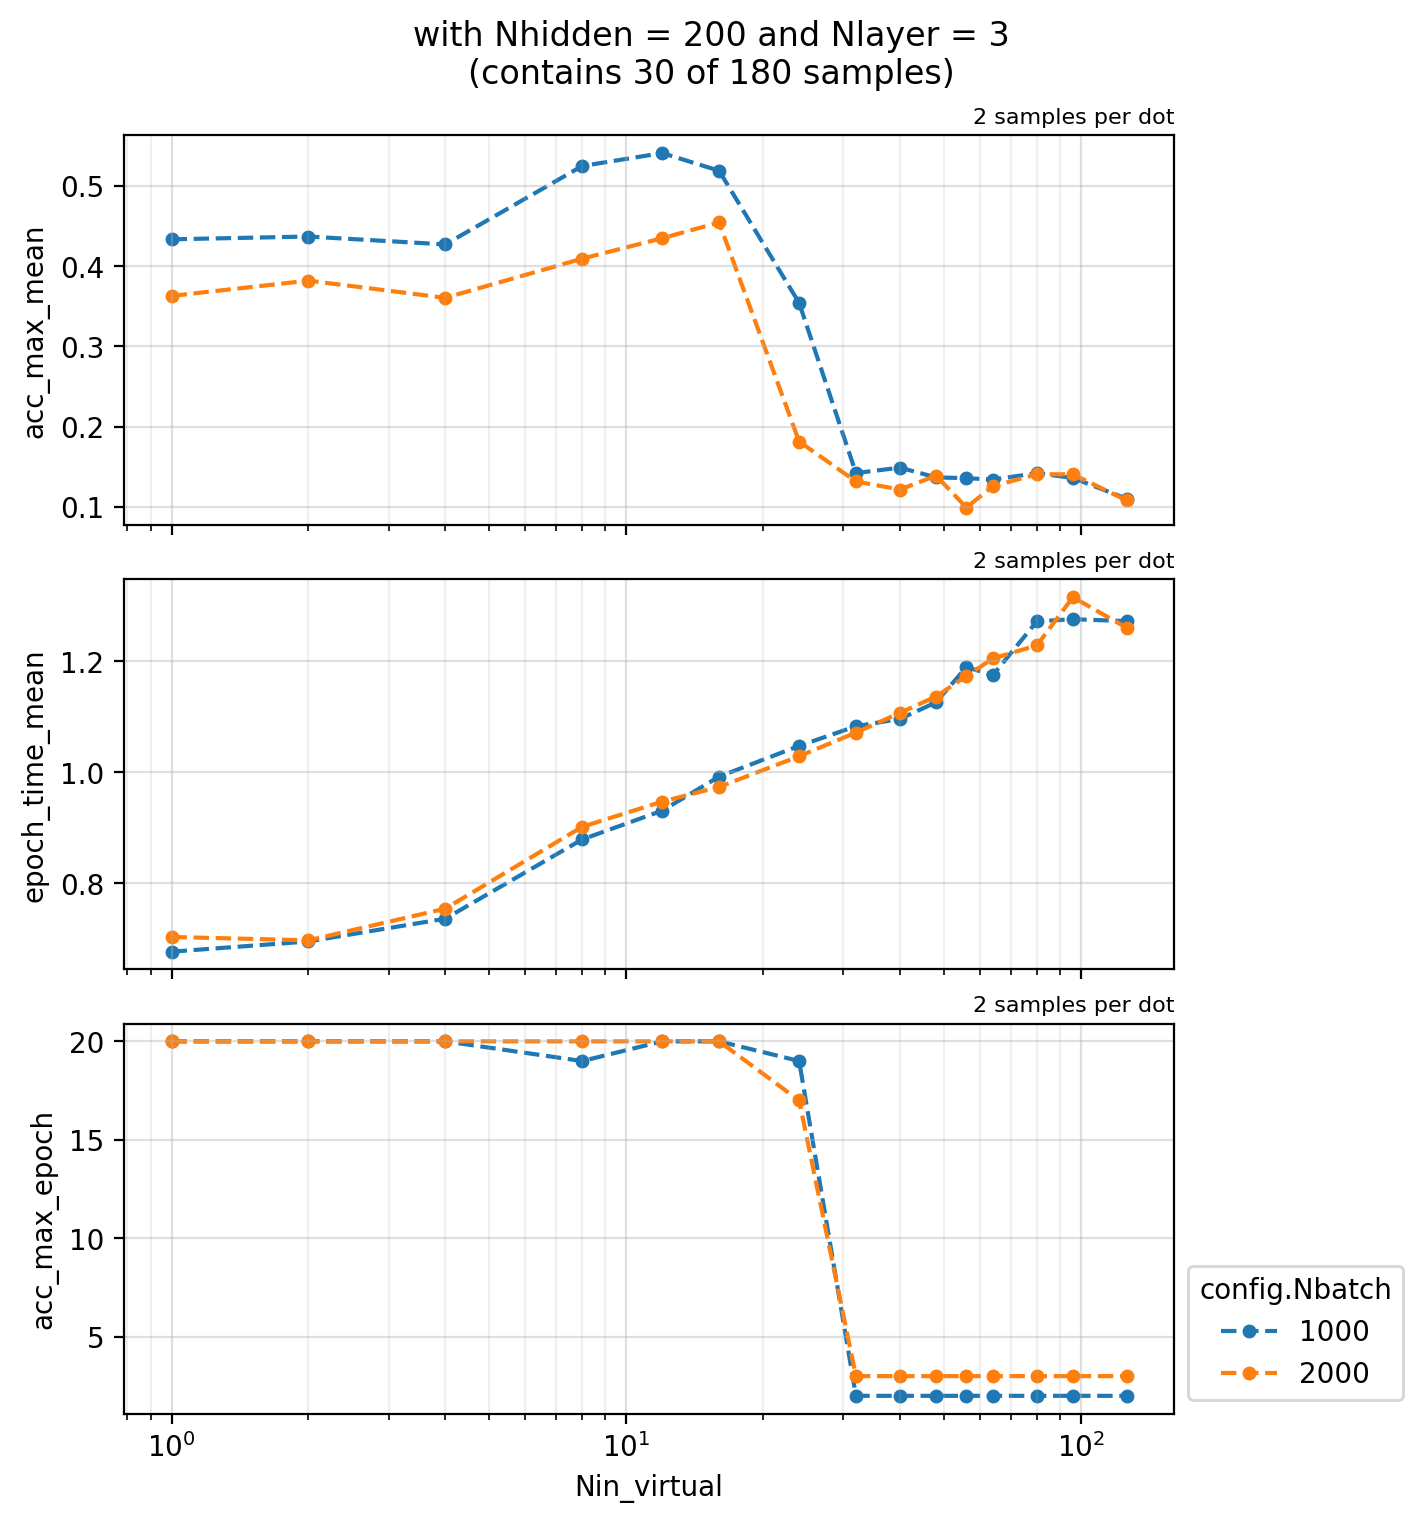

In [23]:
PlotGrid(
    arg_keys=("config.Nin_virtual",),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.epoch_time_mean",
        "metrics.acc_max_epoch"
    ),
    plot_type=LinePlot(
        graph_key="config.Nbatch",
        x_scale="log",
    ),
    # whitelists={"config.Nt": [8, 12, 16]},
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

Independent key 'config.Nbatch' has multiple values: [1000, 2000]. Using most frequent value: 1000


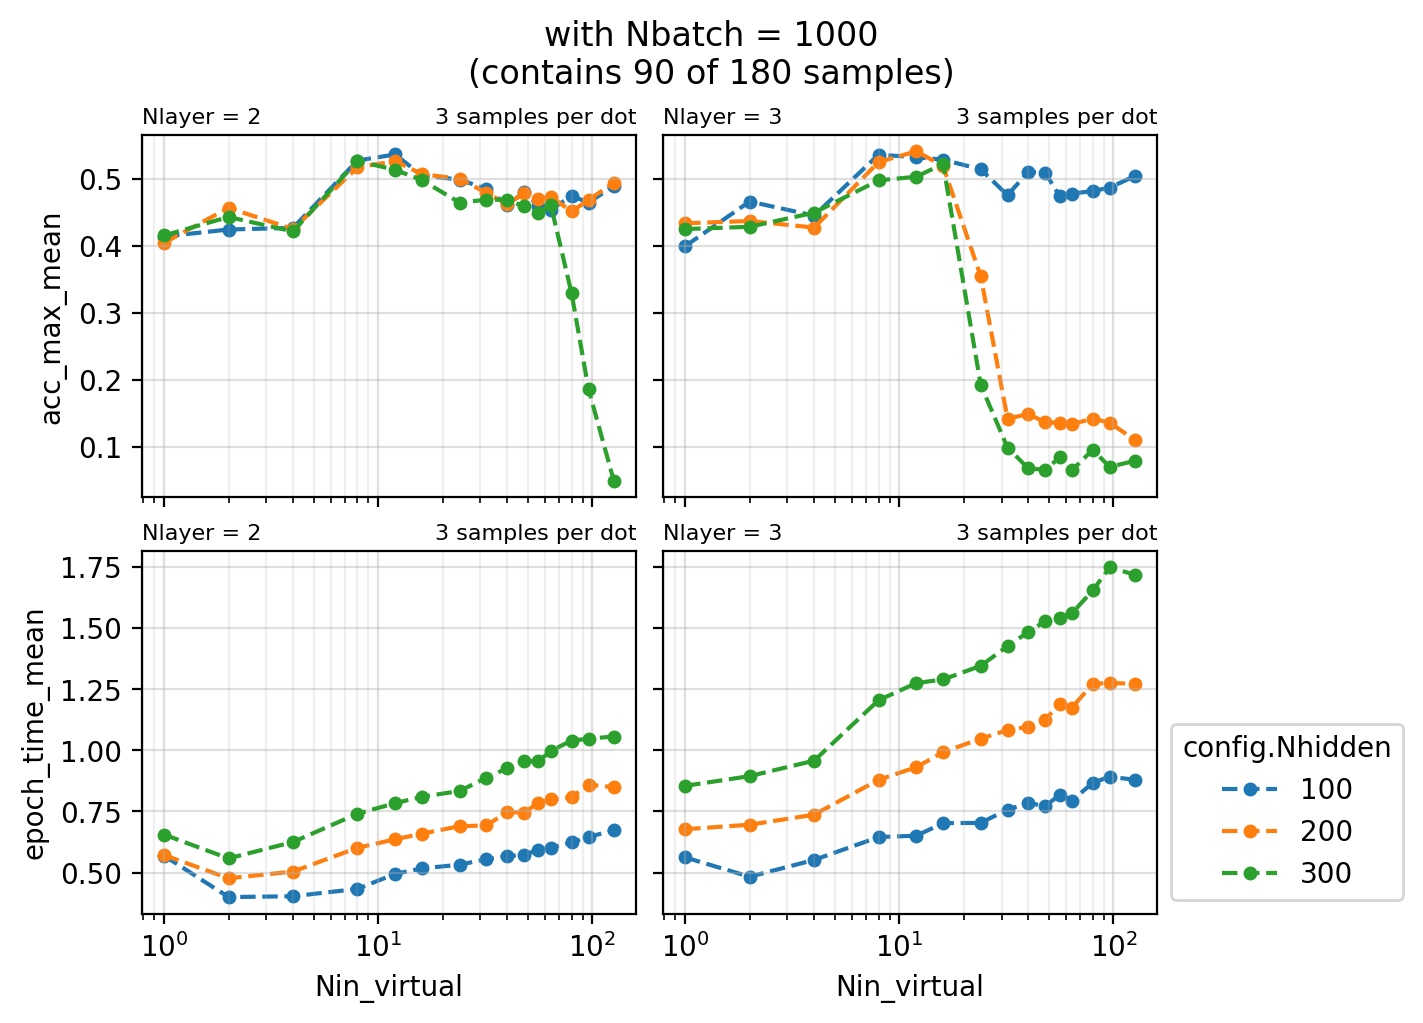

In [22]:
PlotGrid(
    arg_keys=("config.Nin_virtual",),
    func_keys=(
        "metrics.acc_max_mean",
        "metrics.epoch_time_mean"
    ),
    plot_type=LinePlot(
        graph_key="config.Nhidden",
        x_scale="log",
    ),
    col_key="config.Nlayer",
    # whitelists={"config.Nt": [8, 12, 16]},
    indep_keys=indep_keys,
    key_format=key_format,
).show(trials_df)

## Dependencies on `Nt` and `Nin_virtual`

In [18]:
# from spikegd.utils.plotting import HeatmapPlot
# from matplotlib.colors import LogNorm

# PlotGrid(
#     arg_keys=("config.Nt", "config.Nin_virtual"),
#     func_keys=("metrics.acc_max_mean",),
#     plot_type=HeatmapPlot(),
#     # limits={"metrics.acc_max_mean": (0.7, None)},
#     col_key="config.Nbatch",
#     indep_keys=indep_keys,
#     key_format=key_format,
#     whitelists={"config.Nbatch": [1000, 2000]},
# ).show(trials_df)

In [10]:
# plot_dataframe(
#     trials_df,
#     x_key="config.Nhidden",
#     y_keys=("metrics.acc_max_mean", "metrics.acc_max_epoch", "metrics.epoch_time_mean"),
#     # graph_key="config.Nhidden",
#     # col_key="Nin_virtual",
#     fixed_values={"config.Nlayer": 2, "config.Nbatch": 1000, "config.Nt": 10},
#     mean_keys=("config.Nin_virtual", "config.Nin"),
#     indep_keys="config.*",
#     key_format=key_format,
# )

## Dependence of accuracy on `K`

In [11]:
# plot_single_config_key_dependency(
#     trials_df,
#     y_cols=("metrics.acc_max_mean",),
#     free_key="K",
#     col_key="Nhidden",
#     row_key="Nt",
#     graph_key="Nin_virtual",
#     fixed_values={"p_flip": 0, "Nlayer": 2},
#     mean_keys=("Nin", "Nepochs"), # Nin is computed from Nin_virtual and Nt
#     min_points_per_val=10
# )

Here, we can see that the accuracy is essentially independent of `K`, assuming that `K` is sufficiently high. The case for insufficiently high `K` can be seen for high `Nhidden` on the right.

## Dependence of accuracy and duration on `N_t`

In [12]:
# plot_single_config_key_dependency(
#     trials_df,
#     y_cols=("metrics.acc_max_mean", "duration"),
#     free_key="Nt",
#     fixed_values={"p_flip": 0, "Nhidden": 200, "Nin_virtual": 16, "Nlayer": 2, "Nepochs": 20},
#     mean_keys=("Nin", "K") # Nin is computed from Nin_virtual and Nt
# )

The accuracy plateaus above around `Nt = 7`. The duration on the other hand roughly increases linearly with `Nt`. It should therefore be best to choose a fixed `Nt` (e.g. around 10).

## Best trials

In [13]:
trials_df.sort_values("metrics.acc_max_mean", ascending=False).head(10)

,run_id,config_hash,started_at,finished_at,duration,error,config.device_count,config.seed,config.tau,config.I0,config.eps,config.Nhidden,config.Nlayer,config.Nout,config.w_scale,config.T,config.K,config.dt,config.gamma,config.Nbatch,config.lr,config.tau_lr,config.beta1,config.beta2,config.p_flip,config.Nepochs,config.Ntrain,config.Nin_data,config.Nsamples,config.Nin_virtual,config.Nt,config.Nin,metrics.acc_init_mean,metrics.acc_init_std,metrics.acc_final_mean,metrics.acc_final_std,metrics.acc_min_epoch,metrics.acc_min_mean,metrics.acc_min_std,metrics.acc_max_epoch,metrics.acc_max_mean,metrics.acc_max_std,metrics.acc_ord_init_mean,metrics.acc_ord_init_std,metrics.acc_ord_final_mean,metrics.acc_ord_final_std,metrics.acc_ord_min_epoch,metrics.acc_ord_min_mean,metrics.acc_ord_min_std,metrics.acc_ord_max_epoch,metrics.acc_ord_max_mean,metrics.acc_ord_max_std,metrics.activity_init_mean,metrics.activity_init_std,metrics.activity_final_mean,metrics.activity_final_std,metrics.activity_min_epoch,metrics.activity_min_mean,metrics.activity_min_std,metrics.activity_max_epoch,metrics.activity_max_mean,metrics.activity_max_std,metrics.activity_first_init_mean,metrics.activity_first_init_std,metrics.activity_first_final_mean,metrics.activity_first_final_std,metrics.activity_first_min_epoch,metrics.activity_first_min_mean,metrics.activity_first_min_std,metrics.activity_first_max_epoch,metrics.activity_first_max_mean,metrics.activity_first_max_std,metrics.epoch_time_mean,metrics.epoch_time_std,metrics.init_compile_time_mean,metrics.init_compile_time_std,metrics.init_optim_time_mean,metrics.init_optim_time_std,metrics.init_phi0_time_mean,metrics.init_phi0_time_std,metrics.init_time_mean,metrics.init_time_std,metrics.init_weights_time_mean,metrics.init_weights_time_std,metrics.loss_init_mean,metrics.loss_init_std,metrics.loss_final_mean,metrics.loss_final_std,metrics.loss_min_epoch,metrics.loss_min_mean,metrics.loss_min_std,metrics.loss_max_epoch,metrics.loss_max_mean,metrics.loss_max_std,metrics.loss_ord_init_mean,metrics.loss_ord_init_std,metrics.loss_ord_final_mean,metrics.loss_ord_final_std,metrics.loss_ord_min_epoch,metrics.loss_ord_min_mean,metrics.loss_ord_min_std,metrics.loss_ord_max_epoch,metrics.loss_ord_max_mean,metrics.loss_ord_max_std,metrics.silent_neurons_init_mean,metrics.silent_neurons_init_std,metrics.silent_neurons_final_mean,metrics.silent_neurons_final_std,metrics.silent_neurons_min_epoch,metrics.silent_neurons_min_mean,metrics.silent_neurons_min_std,metrics.silent_neurons_max_epoch,metrics.silent_neurons_max_mean,metrics.silent_neurons_max_std,metrics.silent_neurons_first_init_mean,metrics.silent_neurons_first_init_std,metrics.silent_neurons_first_final_mean,metrics.silent_neurons_first_final_std,metrics.silent_neurons_first_min_epoch,metrics.silent_neurons_first_min_mean,metrics.silent_neurons_first_min_std,metrics.silent_neurons_first_max_epoch,metrics.silent_neurons_first_max_mean,metrics.silent_neurons_first_max_std,metrics.train_time_mean,metrics.train_time_std
318,20240912_105644,4006e1f185dd2d5378ed9ac869b0ba94,2024-09-12_11-38-47_718157,2024-09-12_11-39-35_212061,47.493904,None,1,0,1.909859,1.25,0.000001,100,2,20,0.5,2.0,300,0.001,0.01,1500,0.004,100.0,0.9,0.999,0.0,20,None,700,3,24,12,8400,0.050374,0.003332,0.862492,0.001276,0.0,0.050374,0.003332,11.0,0.864263,0.004972,0.048273,0.004225,0.620643,0.013787,0.0,0.048273,0.004225,20.0,0.620643,0.013787,1.088889e-04,7.700142e-05,0.221662,0.017056,0.0,1.088889e-04,7.700142e-05,19.0,0.221879,0.016117,1.088889e-04,7.700142e-05,0.213989,0.015595,0.0,1.088889e-04,7.700142e-05,19.0,0.215362,0.014607,0.572535,0.043595,0.000602,0.000009,0.001927,0.000096,0.000494,0.000009,3.148273,2.038463,0.000899,0.000033,3.040880,0.000898,0.685767,0.008645,11.0,0.668757,0.053959,0.0,3.040880,0.000898,3.012916,0.0,2.850600,0.014534,20.0,2.850600,0.014534,0.0,3.012916,0.0,0.986667,0.009428,0.096667,0.004714,16.0,0.090000,0.008165,0.0,0.986667,0.009428,0.986667,0.009428,0.096667,0.004714,16.0,0.

In [17]:
best_trial = trials_df.loc[trials_df["metrics.acc_max_mean"].idxmax()]
print("===== BEST TRIAL =====")
print(best_trial[[
    "config_hash", "duration",
    *indep_keys,
    "metrics.acc_max_mean", "metrics.acc_max_std", "metrics.acc_max_epoch"
]])

===== BEST TRIAL =====
config_hash              4006e1f185dd2d5378ed9ac869b0ba94
duration                                        47.493904
config.device_count                                     1
config.seed                                             0
config.tau                                       1.909859
config.I0                                            1.25
config.eps                                       0.000001
config.Nhidden                                        100
config.Nlayer                                           2
config.Nout                                            20
config.w_scale                                        0.5
config.T                                              2.0
config.K                                              300
config.dt                                           0.001
config.gamma                                         0.01
config.Nbatch                                        1500
config.lr                                        